<a href="https://colab.research.google.com/github/mralamdari/Computer-Vision-Projects/blob/main/Unsupervised_Similar_Images_Finder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import os
import cv2
import glob
import IPython
import matplotlib
import numpy as np
import pandas as pd
import tensorflow as tf
from google.colab.patches import cv2_imshow

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive'
!kaggle datasets download -d jessicali9530/stanford-cars-dataset
!unzip \*.zip && rm *.zip
IPython.display.clear_output()

In [16]:
data = glob.glob('/content/cars_train/cars_train/*.jpg')

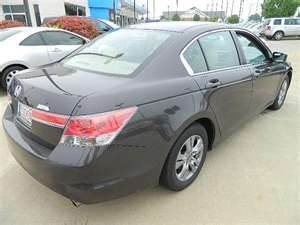

(225, 300, 3)

In [28]:
# N=0
N+=1
img = cv2.imread(data[N])
cv2_imshow(img)
img.shape

169001437/169001437 [==============================] - 4s 0us/step


In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten()
])

# model.summary()
input = tf.keras.layers.Input(shape=(32, 32, 3))
net = model(input)
# keranet.summary()